# Used Car Prices

We will study the sales prices posted for used cars at an online website. In particular, we will focus on the Cars.com and the Turkish website sahibinden.com. In order to get meaningful statistics, we will focus on car models that are popular with high number of posts.

In [239]:
import requests
from bs4 import BeautifulSoup
import json
import string
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#Helper functions to navigate the JSON object converted into python dictionary. Note that
#the dictionary has additional subdictionaries  and lists so the functions handle both.
def searchinlist(l,key):
    for value in l:
        res=None
        if isinstance(value,dict):
            res=findkey(value,key)
        elif isinstance(value,list):
            res=searchinlist(value,key)
        if res!=None:
            return res
    return None        

def findkey(d,key):
    for k in d:
        value=d[k]
        res=None
        if k==key:
            res=value
        elif isinstance(value,dict):
            res=findkey(value,key)
        elif isinstance(value,list):
            res=searchinlist(value,key)
        if res!=None:
            return res
    return None

def listdict(d):
    for key in d:
        value=d[key]
        if isinstance(value,dict):
            print(key+" :")
            listdict(value)
        else:
            print(key," : ",value)

We will start by scraping the used car data from Cars.com. We will study the data for Honda Civic models within 500 miles of my current zip. 

In [3]:
#Initialize Data Frame for Honda Civic data from cars.com
civic = pd.DataFrame()
ps=50
for p in range(ps):
    #Setup the URL of the listings
    URL = 'https://www.cars.com/for-sale/searchresults.action/?dealerType=all&mdId=20823&mkId=20017&page={}&perPage=100&rd=500&searchSource=GN_REFINEMENT&sort=relevance&stkTypId=28881&zc=02151'.format(p+1)
    #Read page
    page = requests.get(URL)
    soup = BeautifulSoup(page.content)
    with open(".\html\page{}.html".format(p), "w",encoding='utf-8') as file:
        file.write(str(soup))
    #Extract json information containing listing data
    result = soup.find_all('script')[2].text[61:-2]
    #Convert json data to dictionary
    res = json.loads(result)
    #Find vehicle information in the dictionary and store in a dataframe
    df1 = pd.DataFrame(findkey(res,'vehicle'))
    #Find additional vehicle information (color,transmission, etc.) in the html and store in a second Data Frame
    cars = soup.find_all('div',class_='listing-row__details')
    vals = []
    for car in cars:
        val = {}
        val['Color Ext'] = car.find_all('li')[0].text.strip().split()[-1]
        val['Color Int'] = car.find_all('li')[1].text.strip().split()[-1]
        val['Transmission'] = car.find_all('li')[2].text.strip().split()[-1]
        val['Drivetrain'] = car.find_all('li')[3].text.strip().split()[-1]
        vals.append(val)
    df2 = pd.DataFrame(vals)
    #Merge the two Data Frames from json and html data sources and append to civic Data Frame
    civic = civic.append(df1.merge(df2,left_index=True,right_index=True))
    if (p+1)%5 ==0:
        print('Completed {} of {} pages'.format(p+1,ps))
    if (p+1)*100>findkey(res,'numResultsReturned'):
        break
civic.reset_index(inplace=True)

#Extract seller information from seller column of civic.
sellerdf=pd.DataFrame(civic['seller'].tolist())

#Drop unnecessary columns from civic and sellerdfs.
civic.drop(columns=['customerId','type','detail','seller'],inplace=True)
sellerdf.drop(columns=['id','phoneNumber2','customerId','formattedPhoneNumber','formattedPhoneNumber2'],inplace=True)

#Merge civic and sellerdf Data Frames
civic=civic.merge(sellerdf,left_index=True,right_index=True)
civic.drop(columns=['index','truncatedDescription'],inplace=True)
civic.head()   
#print(df.shape)

Completed 5 of 50 pages
Completed 10 of 50 pages
Completed 15 of 50 pages
Completed 20 of 50 pages
Completed 25 of 50 pages
Completed 30 of 50 pages
Completed 35 of 50 pages
Completed 40 of 50 pages
Completed 45 of 50 pages
Completed 50 of 50 pages


,index,listingId,stockType,make,makeId,model,modelId,year,trim,bodyStyle,...,distanceFromSearchZip,sellerDisplayLabel,streetAddress,city,state,truncatedDescription,rating,reviewCount,dealerChatProvider,hasCpoShowroomEnabled
0,0,803074978,Used,Honda,20017,Civic,20823,2013,EX,Sedan,...,3,Dealer,100 Broadway,Everett,MA,"NEW BRAKES, RECENT HONDA CARS OF BOSTON TRADE ...",4.9,878,Dealer Inspire,True
1,1,804957670,Used,Honda,20017,Civic,20823,2014,LX,Sedan,...,3,Individual Seller,None,Boston,MA,2014 Honda Civic. I used this car as my daily ...,0.0,0,None,False
2,2,806789627,Used,Honda,20017,Civic,20823,2007,EX,Sedan,...,9,Dealer,97 Andover St,Danvers,MA,Thank you for your interest in one of Ira Suba...,4.6,353,None,False
3,3,805150738,Used,Honda,20017,Civic,20823,2017,LX,Sedan,...,13,Dealer,1575 VFW Parkway,Boston,MA,Odometer is 9291 miles below market average! B...,3.5,124,None,True
4,4,807443129,Used,Honda,20017,Civic,20823,2016,EX-T,Coupe,...,23,Dealer,1150 Westford St,Lowell,MA,Clean CARFAX. Priced below KBB Fair Purchase P...,4.7,249,Dealer Inspire,False


In [74]:
#Save dataframe to file for future use
#civic.to_csv('civic.csv',index=False)
#Load dataframe from file rather than downloading from web
civic=pd.read_csv('civic.csv')

Scrape the description of each car listing:

In [23]:
descs=[]
descriptions=[]
nlistings=len(civic)
print('Completed (N ={}):'.format(nlistings))
for index,car in civic.iterrows():
    URL = 'https://www.cars.com/vehicledetail/detail/{}/overview/'.format(car['listingId'])
    page = requests.get(URL)
    soup = BeautifulSoup(page.content)
    with open(".\html\{}.html".format(car['listingId']), "w",encoding='utf-8') as file:
        file.write(str(soup))
    result = soup.find_all('script',id='listingJson')
    try:
        res = json.loads(result[0].text[2:-1])
        desc = findkey(res,'sellerNotes')
        descs.append({'listingId':car['listingId'],'description':('None' if desc==None else desc)})
        desclist = (['None'] if desc==None else desc.translate(str.maketrans('', '', string.punctuation)).lower().split())
        descriptions.append(desclist)
    except:
        descs.append({'listingId':car['listingId'],'description':'None'})
        descriptions.append(['None'])
    if (index+1)%20 ==0:
        print('{}, '.format(index+1,nlistings),end='')
        
civicdescriptions=pd.DataFrame(descs)

#Use the following for reading data from saved html files
#with open(".\html\output1.html", "r",encoding='utf-8') as file:
#    output1=file.read()
#soup2 = BeautifulSoup(output1,"html.parser")

Completed (N =4936):
20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520, 1540, 1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720, 1740, 1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000, 2020, 2040, 2060, 2080, 2100, 2120, 2140, 2160, 2180, 2200, 2220, 2240, 2260, 2280, 2300, 2320, 2340, 2360, 2380, 2400, 2420, 2440, 2460, 2480, 2500, 2520, 2540, 2560, 2580, 2600, 2620, 2640, 2660, 2680, 2700, 2720, 2740, 2760, 2780, 2800, 2820, 2840, 2860, 2880, 2900, 2920, 2940, 2960, 2980, 3000, 3020, 3040, 3060, 3080, 3100, 3120, 3140, 3160, 3180, 3200, 3220, 3240, 3260, 3280, 3300, 3320, 3340, 3360, 3380, 3400, 3420, 3440, 

In [33]:
civicdescriptions.head()

,listingId,description
0,803074978,"NEW BRAKES, RECENT HONDA CARS OF BOSTON TRADE ..."
1,804957670,2014 Honda Civic. I used this car as my daily ...
2,806789627,Thank you for your interest in one of Ira Suba...
3,805150738,Odometer is 9291 miles below market average! B...
4,807443129,Clean CARFAX. Priced below KBB Fair Purchase P...


In [41]:
#Save dataframe to file
#civicdescriptions.to_csv('civicdescriptions.csv',index=False)

#Load dataframe from file rather than downloading from web
civicdescriptions=pd.read_csv('civicdescriptions.csv')

# Data Exploration:
We will first get some summary statistics of the data.

In [54]:
civic.loc[0]

listingId                                                        803074978
stockType                                                             Used
make                                                                 Honda
makeId                                                               20017
model                                                                Civic
modelId                                                              20823
year                                                                  2013
trim                                                                    EX
bodyStyle                                                            Sedan
certified                                                            False
privateSeller                                                        False
price                                                                11645
mileage                                                              59606
vin                      

In [62]:
cols = ['year','trim','bodyStyle','price','mileage','priceBadge','Color Ext','Color Int','Transmission','Drivetrain']
cols_cat = ['year','trim','bodyStyle','priceBadge','Color Ext','Color Int','Transmission','Drivetrain']
cols_num = ['year','mileage','price']

In [63]:
civic[cols_num].describe()

,year,mileage,price
count,4936.000000,4936.000000,4891.000000
mean,2015.562196,44134.606564,14957.501125
std,3.443771,38796.639295,4662.960239
min,1992.000000,0.000000,700.000000
25%,2015.000000,19510.750000,12997.500000
50%,2017.000000,31661.000000,15900.000000
75%,2017.000000,53281.500000,17890.000000
max,2020.000000,316000.000000,37995.000000


The median values for year, mileage, and price are 2017, 30K, and 16K, respectively. The cheapest car is 700 dollars and the most expensive 38K. It is important to note that some listings have zero mileage. We need to check if this is an omission or cars are nearly brand new. In addition, some listings are missing price. We should drop these entries from the data. 

Let's first check the cars with zero mileage:

In [64]:
civic[civic['mileage']==0][cols]

,year,trim,bodyStyle,price,mileage,priceBadge,Color Ext,Color Int,Transmission,Drivetrain
4786,2000,EX,Coupe,NaN,0,,Other,Other,Automatic,FWD
4812,2004,LX,Coupe,NaN,0,,Other,Other,Automatic,FWD
4813,2009,LX,Sedan,NaN,0,,Other,Other,Automatic,FWD
4814,2017,LX,Sedan,NaN,0,,Gray,Other,CVT,FWD


There are only 4 cars with no mileage. They are also missing the price. So, these listings should be dropped.

In [66]:
civic[civic['price'].isna()].shape

(45, 31)

There are 45 entries (including the 0 mileage ones) with no price label. Some of these were actually not used cars. We will drop all these listings.

We will check if there are any cars with mileage less that 500 miles. We will not categorize these as used cars and will also drop them from the data.

In [90]:
civic[(civic['mileage']<500)][cols].shape

(61, 10)

In [91]:
#combine civic and civicdescriptions:
civic_clean = civic.merge(civicdescriptions,on='listingId')
#Drop rows with no price:
civic_clean.dropna(subset=['price'],inplace=True)
#Drop rows with new cars
civic_clean.drop(civic_clean[(civic_clean['mileage']<500)].index,inplace=True)

In [92]:
civic_clean[cols_num].describe()

,year,mileage,price
count,4841.000000,4841.000000,4841.000000
mean,2015.523652,44677.222681,14892.329684
std,3.426608,38788.503216,4627.847351
min,1992.000000,535.000000,700.000000
25%,2015.000000,19845.000000,12995.000000
50%,2017.000000,31856.000000,15888.000000
75%,2017.000000,54000.000000,17794.000000
max,2020.000000,316000.000000,37995.000000


### Distribution of Cars by Year, Mileage, and Price:

In [ ]:
civic_clean[civic_clean['year']>2000]

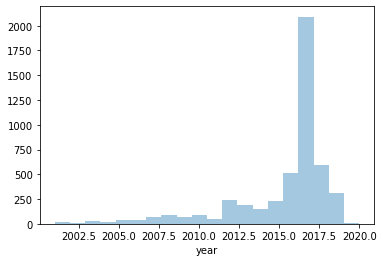

In [110]:
sns.distplot(civic_clean[civic_clean['year']>2000]['year'],kde=False,bins=20)

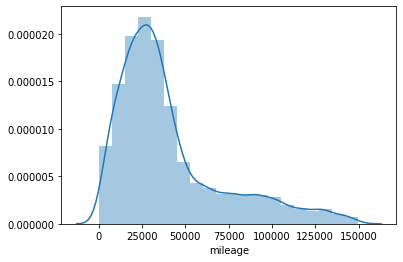

In [119]:
sns.distplot(civic_clean[civic_clean['mileage']<150000]['mileage'],kde=True,bins=20)

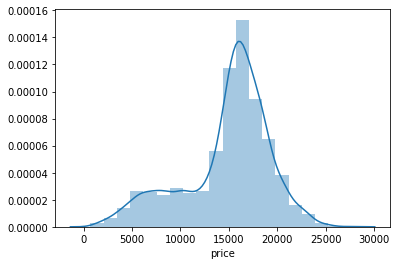

In [118]:
sns.distplot(civic_clean[civic_clean['price']<30000]['price'],kde=True,bins=20)

Clearly, the price distribution is bimodal with peaks at around 8K and 16K. Similarly, the mileage also presents a nearly bimodal distribution with peaks at 30K and 80K. The car year is strongly centered at 2017 with a long tail. The lower price peak is probably originating from older and higher mileage cars and higher price from younger and lower mileage cars.

Let's checkout the mileage and price distribution for the 2017 model cars.

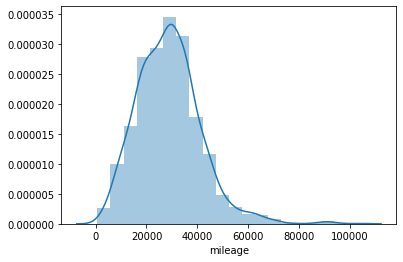

In [120]:
sns.distplot(civic_clean[(civic_clean['year']==2017)&(civic_clean['mileage']<150000)]['mileage'],kde=True,bins=20)

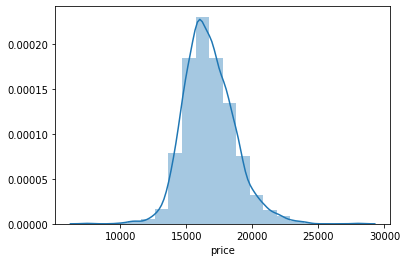

In [121]:
sns.distplot(civic_clean[(civic_clean['year']==2017)&(civic_clean['price']<30000)]['price'],kde=True,bins=20)

The plots above confirm our suspicion.

### Distribution of Categorical Features:

In [145]:
civic_clean['trim'].value_counts()

LX                        2124
EX                        1160
EX-T                       365
EX-L                       283
Si                         242
Sport                      242
Touring                    115
LX-P                        73
Sport Touring               43
EX w/Leather                33
                            32
EX-L w/Navi                 30
LX-S                        16
VP                          14
SE                          13
Type R Touring               9
EX-L w/Navigation            9
EX-L Navi                    6
DX                           5
EX-T w/Honda Sensing         4
High Performance Tires       4
EX-TL                        3
Manual                       3
EX-L Honda Sensing           2
EX w/Honda Sensing           2
LX w/Honda Sensing           2
LX w/ Honda Sensing          2
CX                           1
4DR SDN SI MT                1
ECO                          1
HF                           1
GX                           1
Name: tr

Most common trims are 'LX' and 'EX' models. We might have enough statistics for the first 7 trims to make a comparison.

In [291]:
trims=['LX','EX','EX-T','EX-L','Touring']

In [125]:
civic_clean['bodyStyle'].value_counts()

Sedan          3589
Coupe           648
Hatchback       571
                 32
Convertible       1
Name: bodyStyle, dtype: int64

Sedan is the most popular body type.

In [128]:
civic_clean['Transmission'].value_counts()

CVT           3502
Automatic      861
Manual         465
Automanual       8
Unknown          5
Name: Transmission, dtype: int64

In [130]:
civic_clean['Drivetrain'].value_counts()

FWD        4782
Unknown      49
drive         6
RWD           4
Name: Drivetrain, dtype: int64

Drive train of most cars are the same. So it is not a significant feature in the analysis. 

In [126]:
civic_clean['Color Ext'].value_counts()

Black     1038
Gray      1032
White      771
Blue       720
Silver     631
Red        475
Other       85
Brown       31
Green       23
Beige       14
Gold         9
Orange       8
Purple       3
Yellow       1
Name: Color Ext, dtype: int64

In [127]:
civic_clean['Color Int'].value_counts()

Black     2390
Gray      1170
Other      723
Beige      290
White      255
Blue         5
Brown        3
Red          3
Silver       2
Name: Color Int, dtype: int64

In [ ]:
civic_clean['Color Int'].value_counts()

In [ ]:
'bodyStyle','priceBadge','Color Ext','Color Int','Transmission','Drivetrain']

## Car price vs Features:
We will first reduce the number of features and study how the car prices are affected by each feature. During this analysis, we will initially keep other features constant to better extract functional dependence of each feature.
We suspect that the major factors in **car pricing** are the **year, mileage, trim, bodystyle, and transmission**.


### Mileage vs Price
Let's first check out the price vs. the mileage. For this analysis we will pick cars with year=2017, trim='LX', bodyStyle='Sedan' and transmission='CVT'. 

In [177]:
civic_mileage = civic_clean[(civic_clean['year']==2017) & (civic_clean['trim']=='LX') & 
                         (civic_clean['bodyStyle']=='Sedan') & (civic_clean['Transmission']=='CVT')][['mileage','price','priceBadge']]
civic_mileage.shape

(718, 3)

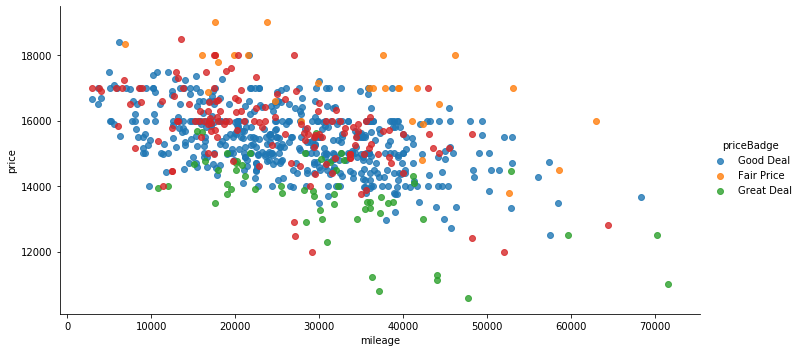

In [141]:
sns.lmplot('mileage', 'price', data=civic_mileage, fit_reg=False,height=5,hue='priceBadge',aspect=2)

The above indicates that the price and the mileage are related to each other almost linearly with a negative slope. An interesting point to note is that the price badges on the Cars.com may be misleading. Clearly the "Great Deal" badges are assigned to cheaper cars but "Good Deals" seems to be averagely priced cars and "Fair Price" cars are on the expensive side of the distribution. Another important thing to note is that the badge categories can not be solely extracted from this plot. There seems to be cars with very similar qualities with different badge assignments (see cars with mileage slightly above 50K and at the upper left corner). Since, all other main features are kept the same, there might be important features that are included in Cars.com analysis). In our subsequent work we will try to figure out if there are clear indicators for the lower pricing of cars other than that can be inferred from this simple analysis.

### Year vs. Price
In this case we will check out the car prices as a function of year. We will keep the type of the cars as similar as possible.

In [142]:
civic_year = civic_clean[ (civic_clean['trim']=='LX') & 
                         (civic_clean['bodyStyle']=='Sedan') & (civic_clean['Transmission']=='CVT')][['year','mileage','price','priceBadge']]
civic_year.shape

(1357, 4)

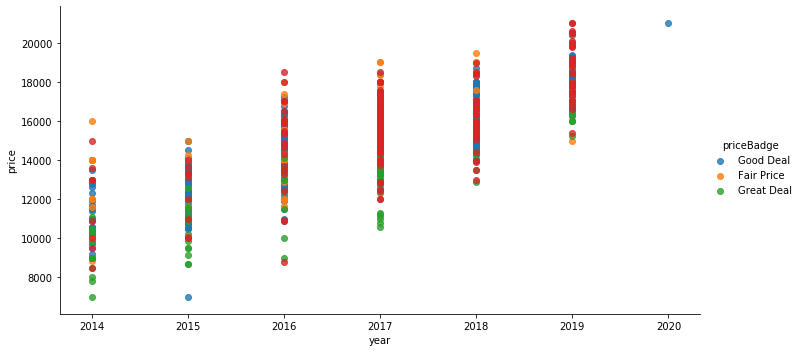

In [144]:
sns.lmplot('year', 'price', data=civic_year, fit_reg=False,height=5,hue='priceBadge',aspect=2)

As expected the car prices are increasing with the car year. The distribution in each year is partially accounted by the mileage dependence of the car. In our analysis, we will assume that the price is a linear function of both mileage and year. Price badges are distributed similar to the previous case but we can also make out listings labelled against our simple intuition.

### Trim vs. Price

In [165]:
civic_trim = civic_clean[(civic_clean['year']==2017) & (civic_clean['trim'].isin(trims)) &
                         (civic_clean['bodyStyle']=='Sedan') & (civic_clean['Transmission']=='CVT')][['trim','mileage','price','priceBadge']]
civic_trim.shape

(1405, 4)

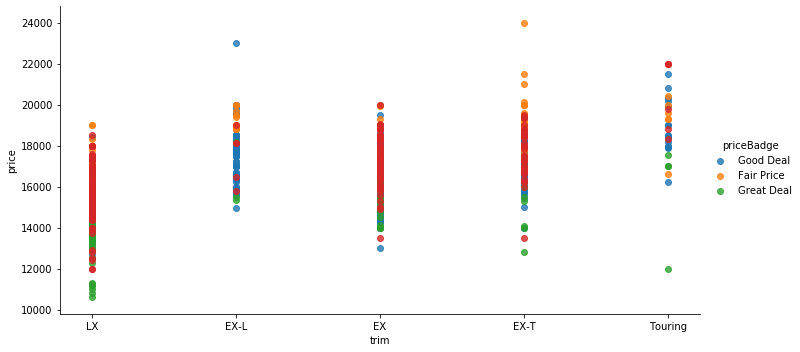

In [157]:
sns.lmplot('trim', 'price', data=civic_trim, fit_reg=False,height=5,hue='priceBadge',aspect=2)

In [160]:
civic_trim.groupby('trim').describe()

mileage                                                         \
          count          mean           std     min       25%      50%   
trim                                                                     
EX        384.0  30035.210938  11777.198598   718.0  21418.50  29789.0   
EX-L       90.0  29793.088889  12734.825284  3927.0  21010.75  30194.0   
EX-T      182.0  31275.576923  11954.850362  8354.0  23968.75  30329.0   
LX        718.0  27216.784123  11635.931182  2928.0  18205.75  27093.0   
Touring    31.0  31698.258065  20184.587199  8014.0  17155.50  30326.0   

                             price                                      \
              75%       max  count          mean          std      min   
trim                                                                     
EX       37392.50   71551.0  384.0  16631.869792  1190.302045  12999.0   
EX-L     37380.50   69259.0   90.0  17800.855556  1396.925264  14950.0   
EX-T     37463.75   70654.0  182.0  17508.670330  1390.778982  12790.0   
LX       35462.50   71566.0  718.0  15401.729805  1183.799174  10595.0   
Touring  37448.00  103992.0   31.0  18895.193548  2020.724910  11988.0   

                                              
             25%      50%       75%      max  
trim                                          
EX       15900.0  16678.5  17395.00  19995.0  
EX-L     16681.5  17898.5  18799.75  22995.0  
EX-T     16735.0  17438.0  18480.00  23995.0  
LX       14700.0  15487.5  15998.00  18995.0  
Touring  17960.5  18990.0  20085.50  21999.0

As expected the car prices depend on the trims. The prices order from lowest to highest is LX, EX, EX-T, EX-L, Touring. Since average mileage of EX models are similar, the price differences can be attributed mainly to trim options.


LX models have significantly lower average mileage. Seems like higher end models are preferred by people who make more mileage.

### Transmission vs Price

In [199]:
civic_transmission = civic_clean[(civic_clean['year']==2017) & (civic_clean['trim']=='LX') &
                         (civic_clean['bodyStyle']=='Sedan')][['Transmission','mileage','price','priceBadge']]
civic_transmission.shape

(761, 4)

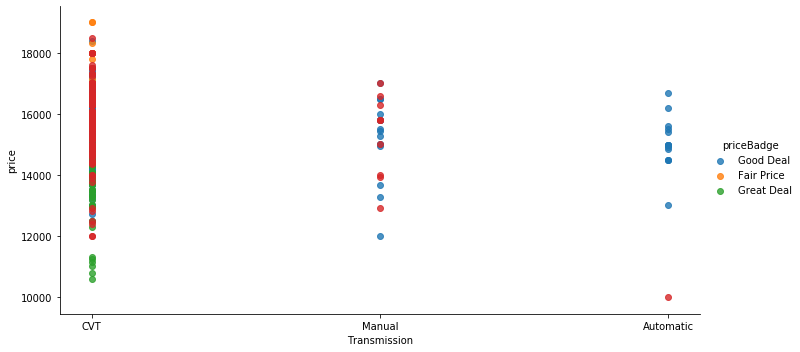

In [200]:
sns.lmplot('Transmission', 'price', data=civic_transmission, fit_reg=False,height=5,hue='priceBadge',aspect=2)

In [201]:
civic_transmission.groupby('Transmission').describe()

mileage                                                         \
               count          mean           std     min       25%      50%   
Transmission                                                                  
Automatic       17.0  30085.058824  19415.224617  5112.0  22025.00  25287.0   
CVT            718.0  27216.784123  11635.931182  2928.0  18205.75  27093.0   
Manual          26.0  29977.576923  13669.116689  7468.0  20902.00  30476.0   

                                 price                                      \
                   75%      max  count          mean          std      min   
Transmission                                                                 
Automatic     31259.00  91500.0   17.0  14735.411765  1452.852714   9990.0   
CVT           35462.50  71566.0  718.0  15401.729805  1183.799174  10595.0   
Manual        31536.75  63420.0   26.0  15251.153846  1276.019614  11995.0   

                                                   
                   25%      50%      75%      max  
Transmission                                       
Automatic     14486.00  14986.0  15400.0  16680.0  
CVT           14700.00  15487.5  15998.0  18995.0  
Manual        14949.25  15645.0  15950.0  16995.0

CVT Transmission is slightly more expensive than manual. However also has lower average mileage. There are also very few Manual cars to make a reliable comparison. 

### Body Style vs Price

In [166]:
civic_body = civic_clean[(civic_clean['year']==2017) & (civic_clean['trim']=='LX') &
                         (civic_clean['Transmission']=='CVT')][['bodyStyle','mileage','price','priceBadge']]
civic_body.shape

(833, 4)

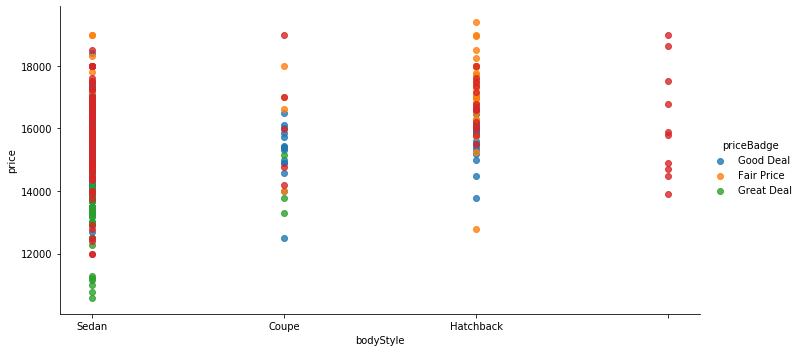

In [167]:
sns.lmplot('bodyStyle', 'price', data=civic_body, fit_reg=False,height=5,hue='priceBadge',aspect=2)

In [168]:
civic_body.groupby('bodyStyle').describe()

mileage                                                          \
            count          mean           std      min       25%      50%   
bodyStyle                                                                   
             10.0  28674.700000  15054.637174   3989.0  23057.00  28441.5   
Coupe        27.0  27638.518519  17520.232195   2440.0  19479.00  26246.0   
Hatchback    78.0  29481.371795  10869.182472  13079.0  22354.50  27940.5   
Sedan       718.0  27216.784123  11635.931182   2928.0  18205.75  27093.0   

                              price                                      \
                75%      max  count          mean          std      min   
bodyStyle                                                                 
           31179.25  64022.0   10.0  16159.700000  1769.129733  13917.0   
Coupe      30625.00  90454.0   27.0  15420.518519  1410.400444  12500.0   
Hatchback  33791.75  85700.0   78.0  16548.153846  1106.585893  12795.0   
Sedan      35462.50  71566.0  718.0  15401.729805  1183.799174  10595.0   

                                                 
                25%      50%       75%      max  
bodyStyle                                        
           14743.25  15844.5  17329.75  18997.0  
Coupe      14681.00  15388.0  16049.50  18998.0  
Hatchback  15991.25  16466.0  17252.50  19390.0  
Sedan      14700.00  15487.5  15998.00  18995.0

It appears that on the average Coupe and Sedan body types have very similar prices and less expensive then Hatchback Civic. In this case the number of coupe and hatchback listings are low and susceptible and likely susceptible to other parameters.

### External Color vs Price

In [169]:
civic_color = civic_clean[(civic_clean['year']==2017) & (civic_clean['trim']=='LX') &
                         (civic_clean['bodyStyle']=='Sedan') & (civic_clean['Transmission']=='CVT')][['Color Ext','mileage','price','priceBadge']]
civic_color.shape

(718, 4)

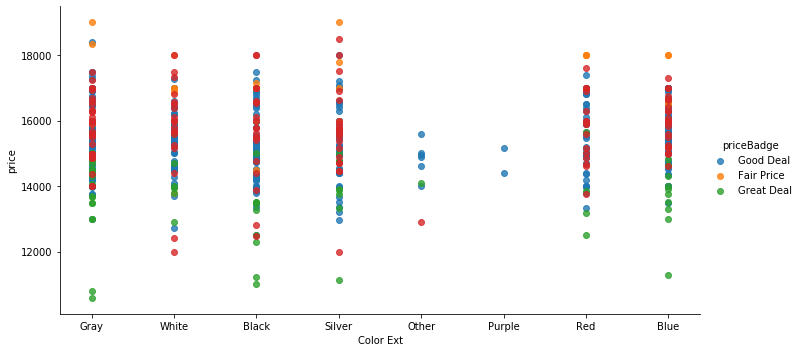

In [171]:
sns.lmplot('Color Ext', 'price', data=civic_color, fit_reg=False,height=5,hue='priceBadge',aspect=2)

In [172]:
civic_color.groupby('Color Ext').describe()

mileage                                                          \
            count          mean           std      min       25%      50%   
Color Ext                                                                   
Black       137.0  30974.189781  11144.116302   4952.0  24358.00  30151.0   
Blue        122.0  25751.827869  11432.353531   2928.0  17315.00  24764.0   
Gray        189.0  26157.661376  11247.331753   3986.0  17191.00  24761.0   
Other         8.0  32218.000000   7498.164518  24425.0  26374.75  30725.0   
Purple        2.0  18201.500000  12935.104348   9055.0  13628.25  18201.5   
Red          64.0  26595.250000  12091.504885   5142.0  17412.50  26578.5   
Silver       99.0  26337.868687  12392.800080   4087.0  17673.50  25201.0   
White        97.0  26896.639175  11585.985050   3652.0  17511.00  26310.0   

                              price                                      \
                75%      max  count          mean          std      min   
Color Ext                                                                 
Black      36238.00  71566.0  137.0  15259.021898  1275.823722  10995.0   
Blue       35572.25  58396.0  122.0  15624.098361  1054.581570  11290.0   
Gray       34248.00  57366.0  189.0  15347.354497  1128.010269  10595.0   
Other      36152.00  44666.0    8.0  14504.250000   826.167356  12900.0   
Purple     22774.75  27348.0    2.0  14784.000000   540.229581  14402.0   
Red        34718.50  70180.0   64.0  15544.125000  1263.372452  12500.0   
Silver     35185.50  68298.0   99.0  15382.191919  1282.315696  11144.0   
White      35119.00  53033.0   97.0  15442.298969  1140.104008  11995.0   

                                                 
                25%      50%       75%      max  
Color Ext                                        
Black      14497.00  15266.0  15998.00  17998.0  
Blue       15000.00  15792.0  16298.75  17999.0  
Gray       14725.00  15288.0  15995.00  18995.0  
Other      14074.75  14748.0  14962.25  15590.0  
Purple     14593.00  14784.0  14975.00  15166.0  
Red        14693.00  15559.0  16498.50  17999.0  
Silver     14709.50  15428.0  15995.00  18995.0  
White      14689.00  15588.0  15999.00  17999.0

In [301]:
colors=['Black', 'Silver', 'Gray', 'Blue',  'White', 'Red']
#vals: 0, 1, 1, 2, 2, 3

Interesting Note: Black cars has significantly larger average/median mileage!!! Other cars have similar average mileage.
Blue cars have the lowest mileage and highest average price and the Black have the highest mileage and lowest average price. Red cars seems to be valued higher despite having near average mileage indicating that they might be more desirable than other colors. It seems that a better analysis of the effect of color might require removing the effect of mileage from the car pricing. 

# Estimate Car Prices

We will conduct a linear regression to estimate car prices based on year, mileage, trim, external color of the car. Since there is not enough statistical data for the transmission and body style, we will only work on 'CVT' transmission and 'Sedan' cars. We will remove privately sold cars (there are only 105 such listings). Finally, we will only include cars with year later than 2000 in our analysis.

In [416]:
civic_price = civic_clean[(civic_clean['year']>2000) & (civic_clean['trim'].isin(trims)) & (civic_clean['privateSeller']==False) &
                         (civic_clean['bodyStyle']=='Sedan') & (civic_clean['Transmission']=='CVT') &
                         (civic_clean['Color Ext'].isin(colors))][['year', 'mileage','trim','Color Ext','price','priceBadge','description']]
civic_price.head()

,year,mileage,trim,Color Ext,price,priceBadge,description
3,2017,16625,LX,Gray,14900.0,Good Deal,Odometer is 9291 miles below market average! B...
5,2016,51080,EX-T,Red,13590.0,,Great MPG: 42 MPG Hwy!!! SPECIAL ONLINE PRICIN...
9,2017,9754,LX,Gray,13999.0,Good Deal,Gray 2017 Honda Civic LX FWD CVT 2.0L I4 DOHC ...
13,2018,11134,EX-T,Blue,15995.0,Good Deal,ATTENTION! ! !!GENERAL PUBLIC!!! PLEASE READ!!...
15,2017,52549,LX,White,13788.0,Fair Price,CARFAX 1-Owner. Taffeta White exterior and Ivo...


In [417]:
civic_price.shape

(2474, 7)

In order to include trim in our linear regression analysis, we will convert the categorical values into numerical values. We will assign values in line with our previous data exploration.

In [418]:
cattonum = {'trim': {'LX':0,"EX": 1, 'EX-T':2,'EX-L':2, 'Touring':3},
            'Color Ext': {'Black': 0, 'Silver':1, 'Gray':1, 'Blue':2,  'White':2, 'Red':3} }
civic_price.replace(cattonum, inplace=True)
civic_price.head()

,year,mileage,trim,Color Ext,price,priceBadge,description
3,2017,16625,0,1,14900.0,Good Deal,Odometer is 9291 miles below market average! B...
5,2016,51080,2,3,13590.0,,Great MPG: 42 MPG Hwy!!! SPECIAL ONLINE PRICIN...
9,2017,9754,0,1,13999.0,Good Deal,Gray 2017 Honda Civic LX FWD CVT 2.0L I4 DOHC ...
13,2018,11134,2,2,15995.0,Good Deal,ATTENTION! ! !!GENERAL PUBLIC!!! PLEASE READ!!...
15,2017,52549,0,2,13788.0,Fair Price,CARFAX 1-Owner. Taffeta White exterior and Ivo...


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Let's first work with a train and validation set to see how well the model works.

In [419]:
features = ['year', 'mileage','trim','Color Ext']
y = civic_price.price
X = civic_price[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y)

model = LinearRegression(fit_intercept=True)
model.fit(train_X,train_y)

#xfit = np.linspace(0, 10, 1000)
lr_val_predictions = model.predict(val_X)
lr_val_mae = mean_absolute_error(lr_val_predictions, val_y)

print("Validation MAE for Linear Regression Model: {:,.0f}".format(lr_val_mae))

Validation MAE for Linear Regression Model: 919


In [420]:
val_ynp=val_y.to_numpy()
mean_val=val_ynp.mean()
err=np.abs(mean_val*(val_ynp-lr_val_predictions)/val_ynp)
err.mean()

942.9199784677353

For an average car price of about 15K, the model makes a mean error of ~900. Since our model is not taking all possible features into account, and variation in car pricing among different sellers is expected, this is a pretty good estimate. However, there are also car prices which is grossly different from model estimation. We will further explore these later.

Below is the same model applied to complete data set. The results are similar.

In [421]:
model = LinearRegression(fit_intercept=True)
model.fit(X,y)

#xfit = np.linspace(0, 10, 1000)
lr_predictions = model.predict(X)
lr_mae = mean_absolute_error(lr_predictions, y)

print("Validation MAE for Linear Regression Model: {:,.0f}".format(lr_mae))

Validation MAE for Linear Regression Model: 911


In [422]:
ynp=y.to_numpy()
mean_y=ynp.mean()
normerr=mean_y*(ynp-lr_predictions)/ynp
normerr.max()

3947.3127957301813

We will now label the original listings based on the model prediction similar to the Cars.com priceBadges. Cars with prices within a certain range of the model estimation will be labeled as 'Good Deal', cars with higher prices will be labeled as 'Fair Price' and cars with less price will be labeled as 'Great Deal'. Then we will compare our labels with that of Cars.com to see how well they agree.

In [423]:
#Add the model predictions to the data_frame
civic_price['pricePrediction']=lr_predictions
civic_price.head()

,year,mileage,trim,Color Ext,price,priceBadge,description,pricePrediction
3,2017,16625,0,1,14900.0,Good Deal,Odometer is 9291 miles below market average! B...,16032.281761
5,2016,51080,2,3,13590.0,,Great MPG: 42 MPG Hwy!!! SPECIAL ONLINE PRICIN...,15788.591665
9,2017,9754,0,1,13999.0,Good Deal,Gray 2017 Honda Civic LX FWD CVT 2.0L I4 DOHC ...,16403.752851
13,2018,11134,2,2,15995.0,Good Deal,ATTENTION! ! !!GENERAL PUBLIC!!! PLEASE READ!!...,19615.115195
15,2017,52549,0,2,13788.0,Fair Price,CARFAX 1-Owner. Taffeta White exterior and Ivo...,14135.921137


In [424]:
dev = 900
#We will label expensive cars as 0 and cheap cars as 1. Average valued cars will be labeled as -1.
civic_price['myBadge']=-1
civic_price.loc[(normerr>dev),'myBadge']=0
civic_price.loc[(normerr<-dev),'myBadge']=1
civic_price['myBadge'].value_counts()

-1    1455
 1     548
 0     471
Name: myBadge, dtype: int64

Let's plot car prices again in a similar manner to the way we plotted the mileage analysis earlier.

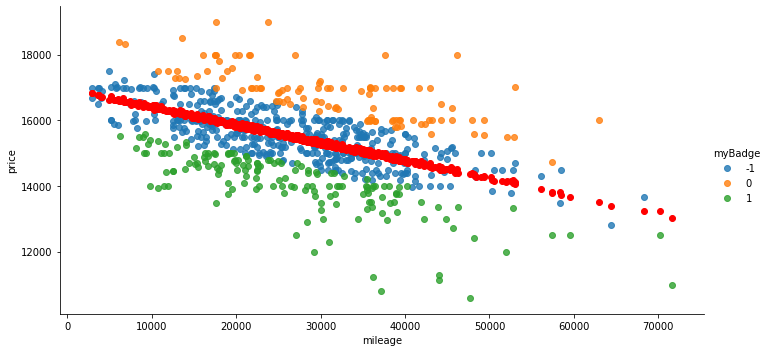

In [425]:
civic_price_m = civic_price[(civic_price['year']==2017) & (civic_price['trim']==0)]
sns.lmplot('mileage', 'price', data=civic_price_m, fit_reg=False,height=5,hue='myBadge',aspect=2)
plt.scatter(civic_price_m['mileage'],civic_price_m['pricePrediction'],c='r')

In [395]:
#Expensive 'Fair Price' cars according to our analysis
civic_price[normerr>dev]['priceBadge'].value_counts()

Good Deal     234
Fair Price    123
              113
Great Deal      1
Name: priceBadge, dtype: int64

In [396]:
#Cheap 'Great Deal' cars according to our analysis
civic_price[normerr<-dev]['priceBadge'].value_counts()

Good Deal     356
Great Deal    128
               60
Fair Price      4
Name: priceBadge, dtype: int64

In [397]:
#Fair priced 'Good Deal' cars according to our analysis
civic_price[np.abs(normerr)<dev]['priceBadge'].value_counts()

Good Deal     1081
               257
Fair Price      69
Great Deal      48
Name: priceBadge, dtype: int64

As can be seen from the summaries above, many cars fall into categories that they shoud not be in. The inconsistencies can not be resolved by increasing 'dev'. We might be missing some very important features that are included in Cars.com analysis OR their labeling algorithm is not working very well.
For now, we will assume that we are missing some features in our analysis.

## Analyze Descriptions for Price Indicators:

In this part we will try to figure out if the descriptions of the listings have any key words that might explain price irregularities relative to our linear regression model. 

In [415]:
import sklearn as sk
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

In [532]:
#Drop rows with no description
civic_price_d=civic_price.drop(civic_price[civic_price['description']=='None'].index)

### Simple Test:
As an initial test, we will label cars with above average price as expensive and cars with below average price as cheap.

In [533]:
#Training Labels
avgprice=civic_price_d['price'].mean()
cheap=(civic_price_d['price']<avgprice)
pricelabels=(cheap*1).to_numpy()

Form a word vector.

In [534]:
vectorizer = CountVectorizer(analyzer='word',max_features=4000)
vector = vectorizer.fit_transform(civic_price_d['description'].values)
#print(len(vectorizer.get_feature_names()))
#vector.toarray()[0]

Let's check out the most common words:

In [535]:
sum_words = vector.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:10]

[('the', 9315),
 ('and', 8331),
 ('to', 6800),
 ('of', 6012),
 ('honda', 5350),
 ('for', 4856),
 ('with', 4081),
 ('vehicle', 3834),
 ('warranty', 3816),
 ('we', 3728)]

Many of these words (the, and, to, of, for, with, we) are irrelevant to the task and should be dropped from the data set. We will do this clean up at a later time.

In [528]:
#words_freq[-20:]

In [446]:
countList = vector.toarray()
#Rescale the countlist for better performance
countList_scaled = preprocessing.scale(countList)

In [448]:
# Logistic regression
logisticRegr = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
logisticRegr.fit(countList_scaled, pricelabels)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [477]:
#Get the regression coefficients of each word
invertedDict = {value: key for key, value in vectorizer.vocabulary_.items()}
wordCoef = [(invertedDict[i],logisticRegr.coef_[0,i]) for i in range(len(logisticRegr.coef_[0,:]))]
sortedWordCoef = sorted(wordCoef,key=lambda x:x[1],reverse=True)

In [478]:
print("Top 20 words related to cheap cars:")
sortedWordCoef[:20]

Top 20 words related to cheap cars:


[('lx', 0.718039897946154),
 ('2015', 0.7154759452040848),
 ('2016', 0.4745779408874929),
 ('2014', 0.46894876250196893),
 ('39', 0.35613432314348786),
 ('rating', 0.21866857925712993),
 ('bags', 0.2051434248662977),
 ('http', 0.19441455763898371),
 ('want', 0.17979258894819347),
 ('credit', 0.17831320701970818),
 ('priced', 0.17660007277336906),
 ('see', 0.1758330084048264),
 ('pick', 0.17386301785573974),
 ('inside', 0.15302679554588763),
 ('dch', 0.1529557126909461),
 ('satisfying', 0.15081751419456388),
 ('15', 0.14993747160628323),
 ('trade', 0.14923698205092703),
 ('41', 0.14703735112725808),
 ('46', 0.13483668863317613)]

In this simple case, where we labeled car prices relative to the median, the top word is 'lx' which is clear indication that 'lx' models are cheaper than other trims. The next three keywords 2015, 2016 and 2014 are also cheap car indicators. This is probably the year of the car and since most cars are 2017, probably the average car price falls into the 2017 car range. Therefore, these years car cheap car indicator. Other, key words like 'bags' might be part of 'air bags' and included in the description due to lack of features in the cheaper model. 'priced' is also a low price indicator in this list.

In [479]:
print("Top 20 words related to expensive cars:")
sortedWordCoef[:-20:-1]

Top 20 words related to expensive cars:


[('odometer', -0.528331097396113),
 ('38', -0.3427949481128265),
 ('781', -0.2703324510817523),
 ('2018', -0.2666538707256362),
 ('2019', -0.2490545432533281),
 ('sunroof', -0.24010770120223743),
 ('follow', -0.22489777826154825),
 ('moonroof', -0.2132295105925823),
 ('nation', -0.21012954466761635),
 ('866', -0.19799467903356957),
 ('turbocharged', -0.19649030565099337),
 ('mile', -0.1671583098906452),
 ('ex', -0.15903518122530932),
 ('winner', -0.15856671109949305),
 ('extras', -0.15420423867380023),
 ('automobile', -0.15146838584150588),
 ('42', -0.1461330373260682),
 ('lane', -0.14437731372278254),
 ('android', -0.13173505414846515)]

In this simple case, we see that car years 2018 and 2019 are expensive car indicators. In addition, 'odometer' might be an indicator for low mileage. Also 'mile' is in this list. Sellers probably want to advertise the low mileage of the car. 'sunroof' and 'moonroof' are two words that is not considered in our models at all. 'extras' is also a high price indicator. Finally, 'android'  might be related to some electronic options available in the car and shows up in more expensive listings.

### Use linear regression labels:

We will now use the result of the linear regression fit for the price estimation. We will assume that cars priced within the MAE of the linear regression are fairly priced. In the logistic regression, we will only compare highly priced cars to cheap cars. In the future we might attempt to do a multi class classification. 

In [562]:
dev = 900
#We will label expensive cars as 0 and cheap cars as 1. Average valued cars will be labeled as -1.
civic_price['myBadge']=-1
civic_price.loc[(normerr>dev),'myBadge']=0
civic_price.loc[(normerr<-dev),'myBadge']=1
civic_price['myBadge'].value_counts()


-1    1455
 1     548
 0     471
Name: myBadge, dtype: int64

In [563]:
#Drop rows with no description
civic_price_d = civic_price.drop(civic_price[civic_price['description']=='None'].index)
civic_price_d = civic_price_d[civic_price_d['myBadge']>=0]
pricelabels = civic_price_d['myBadge'].to_numpy()

In [564]:
vectorizer = CountVectorizer(analyzer='word',max_features=2500)
vector = vectorizer.fit_transform(civic_price_d['description'].values)
print(len(vectorizer.get_feature_names()))
#vector.toarray()[0]

2500


In [565]:
sum_words = vector.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
#words_freq[-20:]

In [518]:
#Generate the training data
countList = vector.toarray()
#Rescale the countlist for better performance
countList_scaled = preprocessing.scale(countList)

In [519]:
# Logistic regression
logisticRegr = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
logisticRegr.fit(countList_scaled, pricelabels)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [520]:
#Get the regression coefficients of each word
invertedDict = {value: key for key, value in vectorizer.vocabulary_.items()}
wordCoef = [(invertedDict[i],logisticRegr.coef_[0,i]) for i in range(len(logisticRegr.coef_[0,:]))]
sortedWordCoef = sorted(wordCoef,key=lambda x:x[1],reverse=True)

In [526]:
print("Top 20 words related to cheap cars:")
sortedWordCoef[:20]

Top 20 words related to cheap cars:


[('below', 0.3510256841574345),
 ('sale', 0.3441466325423583),
 ('so', 0.2916148290314003),
 ('price', 0.2872919727696088),
 ('registration', 0.2775619625399668),
 ('located', 0.209668719477975),
 ('thank', 0.20508760896345796),
 ('jersey', 0.2003636796904007),
 ('is', 0.18761595242831441),
 ('drives', 0.18637081658134114),
 ('advertised', 0.18311188812898482),
 ('past', 0.17418630836813995),
 ('talk', 0.17216429672290673),
 ('llc', 0.16186575307297976),
 ('like', 0.1468086751914159),
 ('spot', 0.14274158724841818),
 ('reverse', 0.1423566044285284),
 ('aux', 0.13505365813918163),
 ('good', 0.1293695530786608),
 ('trade', 0.1262352410061725)]

Cheap price indicators such as 'below', 'sale', 'price', 'advertised' might point to a reduced price for the car to sell it quickly. 'jersey' might be car location (New Jersey?). 'drives *good*' 'like *new*' could be terms used most often for cheaper, poorer condition cars. Words that needs to be looked more closely are 'registration', 'located', 'thank', 'past', 'talk', 'llc', 'spot', 'reverse', 'trade'.

* "All advertised are only after $1995 down payment and finance" !!! 
* "past negative credit history"
* "blind spot detection"
* "reverse camera"

In [524]:
print("Top 20 words related to expensive cars:")
sortedWordCoef[:-20:-1]

Top 20 words related to expensive cars:


[('law', -0.4881923414727516),
 ('learn', -0.45285694193120163),
 ('automotive', -0.34633753422735314),
 ('000', -0.32955290098755824),
 ('courteous', -0.2766374772612237),
 ('haggle', -0.27039044103972754),
 ('carvana', -0.21545728463919306),
 ('charging', -0.19052390424438595),
 ('hondacare', -0.18679016802195883),
 ('car', -0.186696471412142),
 ('art', -0.16718268056908492),
 ('nation', -0.1632922779355101),
 ('hondas', -0.14283972156056315),
 ('virginia', -0.1427997039892348),
 ('if', -0.13966908652776358),
 ('extra', -0.13344624008652628),
 ('lifetime', -0.13193099884126055),
 ('ten', -0.12417024290249062),
 ('hundreds', -0.1087226136445354)]

The words like 'hondas', 'hondacare', 'lifetime' might indicate some sort of warranty offered by the car. 
'virginia' points to Virginia. 

'extra' probably points to some additional features of the car explaining the higher price. 

'charging': USB charging and price match.

The following three words appears to be used commonly be certain car listers. The higher price is not associated with the features of the car but rather with the listing dealer.

* 'law' : "not required by law" the context is usually dealer processing fees...
* 'learn': "learn if this vehicle has a ..." 
* 'automotive'
* 'courteous'
* 'haggle': "no-haggle price"
* 'Carvana'
* 'hundreds'
* 'art': 'state or the art showroom/facility" - a clear sign of high price tag based on the dealer brand value!
* 'ten': 'ten-car show room'

In [602]:
index=civic_price_d['description'].str.contains('charging',case=False)
for desc in civic_price_d[index & (civic_price_d['myBadge']==0)]['description']:
    print(desc)
    print("**********************")

Civic Touring, 4D Sedan, CVT, Clean Autocheck, Bluetooth, Hands-Free Cellphone, Navigation, Sunroof / Moonroof, Ipod Adapter, Clean Vehicle History Report!, Diagnostic Alerts, USB charging ports, Streaming Music, Honda Sensing Safety, Lane Keep Assist, Road Departure Mitigation, Blind Spot Camera, Android Auto, Apple CarPlay, Backup Camera, Bluetooth, Hands-Free, Heated Seats, Keyless Entry, Leather Seats. Certified. Modern Steel Metallic 2017 Honda Civic Touring FWD CVT 1.5L I-4 DI DOHC Turbocharged 1-Owner vehicle with only 13k Miles. Fully serviced and Honda Certified for 7 years or 100,000 miles. Market Based Pricing- compare- won't last! Nicely equipped with features such as * Recent Arrival! Odometer is 14942 miles below market average! 32/42 City/Highway MPG HondaTrue Certified Details: * Roadside Assistance for the duration of the Certified Pre-Owned Limited Warranty. Up to two complimentary oil changes within the first year of ownership. SiriusXM 90-Day Trial * Limited Warrant

Clearly many descriptions does not contain car specific information but rather a description of the dealer itself and the fine print regarding car sales. This is not very helpful in identifying car specific features that affect its price. However, the analysis also indicates that the variation in pricing is also strongly connected with the pricing policies of individual dealers. Some put a higher price tag on their stock than others.

Another important aspect that came out of this analysis is many car prices does not reflect the full cost of that item. In particular, there is a wide range of dealer processing fees (~100 to 1000 dollars) that is not included in the price. In judging whether a car is cheap or not, similar additional fees must be takin into account. There are also cases whith a down-payment clause. This might be a mistake in connection with leased cars. But should be looked into. 

It might be the case that some dealers are using a "bait and switch" strategy by advertising cars at a below market value when in fact the car is no longer the part of their inventory or by misrepresenting the features of the car. This must too be investigated more carefully.

Finally, we should identify other car specific features presented in the listings that affect the price (sunroof, moonroof, etc.).

---

Below is an another exercise for the Turkish website Sahibinden.com. In this case "requests" package failed to download information from the website so I used selenium for web scraping:

In [2]:
chromepath='C:\\chromedriver\\chromedriver.exe'
driver=webdriver.Chrome(chromepath)
#driver=webdriver.Firefox(executable_path=r'C:\chromedriver\geckodriver.exe')

In [7]:
#Close driver.
driver.close()

The following function will scrape data from the "Sahibinden.com" website and store values in a pandas data object.

In [4]:
#This function scrapes data from sahibinden.com while keeping track of car transmission and seller type info.
def getdata2(carmodel,pages=1):
    #Root of the website
    site = 'https://www.sahibinden.com'
    #A dictionary of months for translation into english.
    months = {'Ocak'  : 'January',  'Şubat'   : 'February', 'Mart'   : 'March',  'Nisan'    : 'April',
              'Mayıs' : 'May',      'Haziran' : 'June',     'Temmuz' : 'July',    'Ağustos' : 'August',
              'Eylül' : 'September', 'Ekim'   : 'October',  'Kasım' : 'November', 'Aralık'  : 'December'}
    #Column names in the data 
    cols = ['id', 'model', 'title','link', 'modelyear', 'mileage', 
            'color', 'price', 'day', 'month', 'year', 'province', 'district','transmission','seller']
    rowsperpage = 50
    transmissions = ['manuel','yari-otomatik','otomatik'] #trasmission type (manual, semi-automatic, or automatic)
    sellers = ['sahibinden', 'galeriden'] #who is the seller (owner or dealer)
    
    data = pd.DataFrame(columns=cols)
    nposts = 1
    for transmission in transmissions:
        for seller in sellers:
            for i in range(pages):
                URL = site + carmodel + '/' + transmission + '/' + seller +'?pagingOffset={}&pagingSize={}'.format(i*rowsperpage,rowsperpage)
                driver.get(URL)
                content = driver.page_source
                soup = BeautifulSoup(content)
                if i==0:
                    nposts = soup.find('div',class_="result-text").find('span',title=None).text.split()[0]
                    if '.' in nposts:
                        nposts=int(float(nposts)*1E3)
                    else:
                        nposts=int(nposts)
                nposts=nposts-rowsperpage
                results = soup.find('tbody',class_="searchResultsRowClass")
                results2 = results.find_all('tr')
                for result in results2:
                    row = {}
                    if result.find('td',class_ = "searchResultsTagAttributeValue") == None:
                        continue
                    row['id'] = result['data-id']
                    row['model'] = " ".join(result.find('td',class_="searchResultsTagAttributeValue").text.strip().split()[3:])
                    if row['model'] == '':
                        row['model'] = 'none'
                    row['title'] = result.find('a',class_="classifiedTitle").text.strip()
                    row['link'] = site+result.find('a',class_="classifiedTitle")['href']
                    [row['modelyear'], row['mileage'], row['color']] = [val.text.strip() for val in result.find_all('td', class_="searchResultsAttributeValue")]
                    if '.' in row['mileage']:
                        row['mileage'] = int(float(row['mileage'])*1E3)
                    else:
                        row['mileage'] = int(row['mileage'])
                    row['price'] = result.find('td', class_="searchResultsPriceValue").text.strip()
                    row['price'] = int(float(row['price'].split()[0])*1E3)
                    [row['day'], row['year']] = [val.text.strip() for val in result.find('td', class_="searchResultsDateValue").find_all('span')]
                    [row['day'],row['month']] = row['day'].split()
                    row['month'] = months[row['month']]
                    [row['province'], row['district']] = result.find('td', class_="searchResultsLocationValue").get_text(separator=" ").split()
                    row['transmission'] = transmission
                    row['seller'] = seller
                    data = data.append(row,ignore_index=True)
                print(nposts)
                if nposts<0:
                    break
    col_types = {'id':int,'modelyear':int, 'mileage':int, 'price':int, 'day':int, 'year':int}
    data = data.astype(col_types)
    return data

In [4]:
def getdescription(link):
    driver.get(link)
    content = driver.page_source
    soup = BeautifulSoup(content)
    result = soup.find('div',class_="uiBoxContainer")
    description=''
    for string in result.strings:
        description=description+" "+string.strip()
    description=description.replace(',',' ').replace('.',' ').strip()
    print(description)

In [198]:
#This code is written to extract data from sahibinden com.
def getdata(carmodel,pages=1):
    #Root of the website
    site = 'https://www.sahibinden.com'
    #A dictionary of months for translation into english.
    months = {'Ocak'  : 'January',  'Şubat'   : 'February', 'Mart'   : 'March',  'Nisan'    : 'April',
              'Mayıs' : 'May',      'Haziran' : 'June',     'Temmuz' : 'July',    'Ağustos' : 'August',
              'Eylül' : 'September', 'Ekim'   : 'October',  'Kasım' : 'November', 'Aralık'  : 'December'}
    #Column names in the data 
    cols = ['id', 'model', 'title','link', 'modelyear', 'mileage', 
            'color', 'price', 'day', 'month', 'year', 'province', 'district','transmission','seller']
    rowsperpage = 50
    transmission = ['manuel','yari-otomatik','otomatik'] #trasmission type (manual, semi-automatic, or automatic)
    seller = ['sahibinden', 'galeriden'] #who is the seller (owner or dealer)
    
    data = pd.DataFrame(columns=cols)
    for i in range(pages):
        URL = site + carmodel + '?pagingOffset={}&pagingSize={}'.format(i*rowsperpage,rowsperpage)
        driver.get(URL)
        content = driver.page_source
        soup = BeautifulSoup(content)
        results = soup.find('tbody',class_="searchResultsRowClass")
        results2 = results.find_all('tr')
        for result in results2:
            row = {}
            if result.find('td',class_ = "searchResultsTagAttributeValue") == None:
                continue
            row['id'] = result['data-id']
            row['model'] = " ".join(result.find('td',class_="searchResultsTagAttributeValue").text.strip().split()[3:])
            if row['model'] == '':
                row['model'] = 'none'
            row['title'] = result.find('a',class_="classifiedTitle").text.strip()
            row['link'] = site+result.find('a',class_="classifiedTitle")['href']
            [row['modelyear'], row['mileage'], row['color']] = [val.text.strip() for val in result.find_all('td', class_="searchResultsAttributeValue")]
            if '.' in row['mileage']:
                row['mileage'] = int(float(row['mileage'])*1E3)
            else:
                row['mileage'] = int(row['mileage'])
            row['price'] = result.find('td', class_="searchResultsPriceValue").text.strip()
            row['price'] = int(float(row['price'].split()[0])*1E3)
            [row['day'], row['year']] = [val.text.strip() for val in result.find('td', class_="searchResultsDateValue").find_all('span')]
            [row['day'],row['month']] = row['day'].split()
            row['month'] = months[row['month']]
            [row['province'], row['district']] = result.find('td', class_="searchResultsLocationValue").get_text(separator=" ").split()
            data = data.append(row,ignore_index=True)
    col_types = {'id':int,'modelyear':int, 'mileage':int, 'price':int, 'day':int, 'year':int}
    data = data.astype(col_types)
    return data

Scrape data and take a look at the first few rows of the data:

In [131]:
carmodel = '/volkswagen-passat-1.6-tdi-bluemotion'
data = getdata(carmodel,40)
data.head()

,id,model,title,link,modelyear,mileage,color,price,day,month,year,province,district
0,789669728,Highline,AYDIN VİNÇ'TEN 2016 MODEL 1.6 TDI DSG HINGLİNE...,https://www.sahibinden.com/ilan/vasita-otomobi...,2016,82656,Gri,194750,23,February,2020,İstanbul,Üsküdar
1,793574908,Highline,WOLFSBURG EDİTİON TAM DOLU HAYALET CAM TAVAN E...,https://www.sahibinden.com/ilan/vasita-otomobi...,2015,108000,Gri,228750,23,February,2020,İstanbul,Güngören
2,793904185,Comfortline,acilll 2017 ÇIKIŞLI 1.6 TDI BLUEMOTİON COMFORT...,https://www.sahibinden.com/ilan/vasita-otomobi...,2016,127000,Beyaz,159500,23,February,2020,İstanbul,Kartal
3,792656711,Comfortline,2013*OTOMATİK DSG F1*ORJINAL*FULL BAKIMLI*EMSA...,https://www.sahibinden.com/ilan/vasita-otomobi...,2013,130000,Beyaz,135750,23,February,2020,Osmaniye,Merkez
4,793773998,Highline,BLUE OTOMOTİV-2018 VOLKSWAGEN PASSAT 1.6 DİZEL...,https://www.sahibinden.com/ilan/vasita-otomobi...,2018,200,Mavi,329900,23,February,2020,İstanbul,Eyüpsultan


Save data into a csv file for future reference.

In [114]:
#data.to_csv('cardata.csv')

In [133]:
#Pick only the 'Comfortline' option for analysis and checkout summary statistics.
cdata = data[data['model']=='Comfortline'].copy()
cdata.describe()

,id,modelyear,mileage,price,day,year
count,1.187000e+03,1187.000000,1187.000000,1187.000000,1187.000000,1187.0
mean,7.913045e+08,2014.604044,118111.682393,168279.078349,21.192081,2020.0
std,1.378849e+07,1.598877,54846.495497,32965.857320,2.088313,0.0
min,5.011544e+08,2010.000000,109.000000,75000.000000,2.000000,2020.0
25%,7.929736e+08,2013.000000,83000.000000,141750.000000,20.000000,2020.0
50%,7.933087e+08,2015.000000,115000.000000,173000.000000,22.000000,2020.0
75%,7.936426e+08,2016.000000,156500.000000,185125.000000,22.000000,2020.0
max,7.940439e+08,2019.000000,293000.000000,278000.000000,30.000000,2020.0


In [134]:
#Check out the summary statistics of the price after grouping by color.
cdata.groupby('color')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
color,,,,,,,,
Bej,6.0,172166.666667,24326.254678,128500.0,166875.0,178000.0,184250.0,199000.0
Beyaz,551.0,169889.925590,32690.487673,92900.0,144125.0,173000.0,190750.0,264900.0
Füme,38.0,198626.315789,42314.775607,95000.0,166875.0,232000.0,232000.0,232000.0
Gri,192.0,177528.333333,24864.008500,75000.0,165000.0,178500.0,183500.0,262000.0
Gümüş Gri,106.0,167636.216981,36404.878109,114750.0,126187.5,180000.0,197750.0,278000.0
Kahverengi,8.0,171237.500000,27669.048592,116000.0,160925.0,176875.0,184062.5,205000.0
Lacivert,9.0,184994.444444,40758.438117,117500.0,173500.0,176500.0,204950.0,245000.0
Mavi,13.0,184346.153846,36082.327516,106500.0,165900.0,193000.0,208000.0,231500.0
Siyah,263.0,152239.117871,28294.045948,75000.0,132000.0,144950.0,173900.0,237000.0


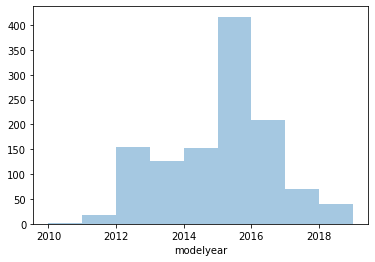

In [201]:
sns.distplot(cdata['modelyear'],kde=False,bins=9)

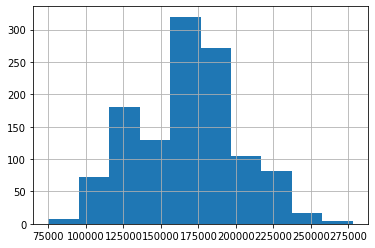

In [120]:
cdata['price'].hist(bins=10)

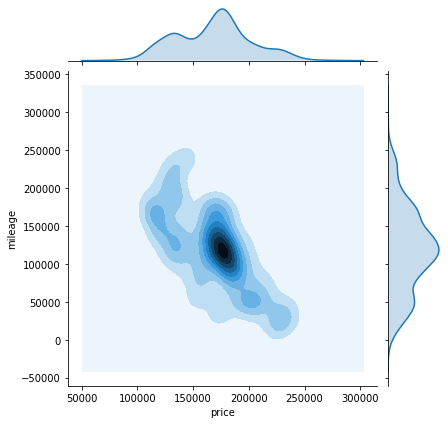

In [140]:
sns.jointplot(x="price", y="mileage", data=cdata, kind="kde");

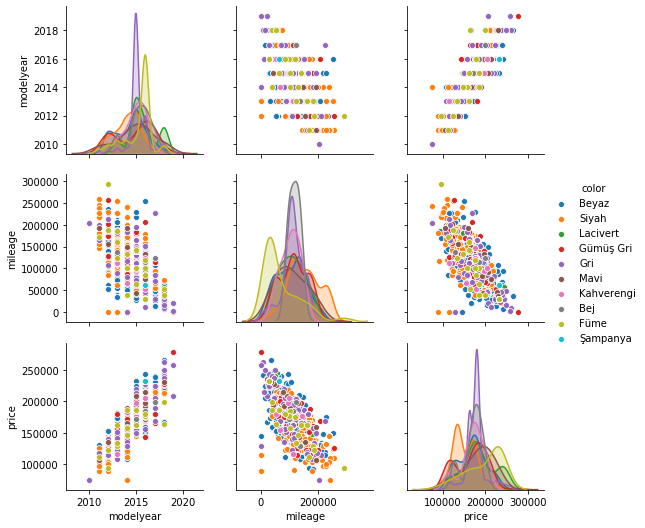

In [144]:
sns.pairplot(cdata[['modelyear','mileage','price','color']], hue="color");

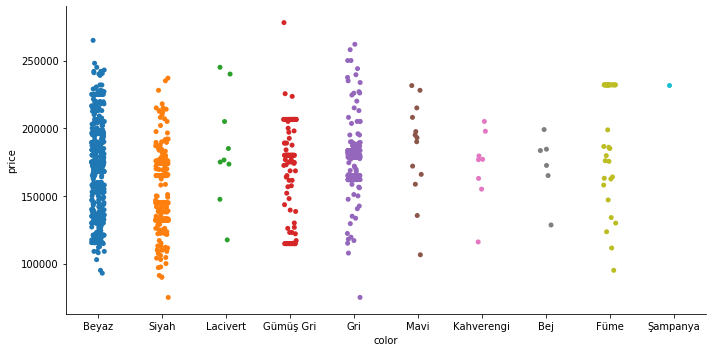

In [147]:
sns.catplot(x="color", y="price", data=cdata,height=5,aspect=2)

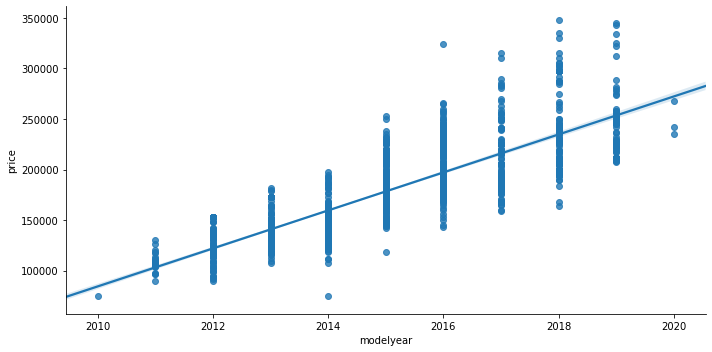

In [124]:
sns.lmplot('modelyear', 'price', data=data, fit_reg=True,height=5,aspect=2)

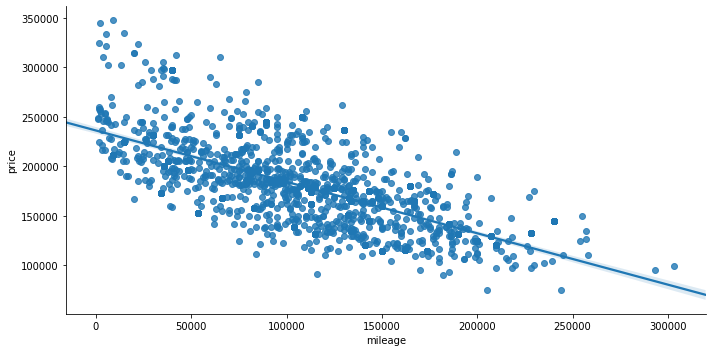

In [125]:
sns.lmplot('mileage', 'price', data=data[(data['mileage']>1000)], fit_reg=True,height=5,aspect=2)

In [107]:
data[(data['mileage']<100000) & (data['price']<125000) & (data['model']=='Comfortline')]

,id,model,title,link,modelyear,mileage,color,price,day,month,year,province,district
166,793908414,Comfortline,Satılık Passat,https://www.sahibinden.com/ilan/vasita-otomobi...,2012,86000,Siyah,122000,23,February,2020,İstanbul,Gaziosmanpaşa
229,793917209,Comfortline,2014 MODEL 100 BİN KM DSG,https://www.sahibinden.com/ilan/vasita-otomobi...,2014,98000,Siyah,122500,23,February,2020,Gaziantep,Nurdağı
405,793558808,Comfortline,2014 model passat comfortline 84.000 de,https://www.sahibinden.com/ilan/vasita-otomobi...,2014,84000,Beyaz,112000,22,February,2020,Şanlıurfa,Haliliye
508,794022084,Comfortline,2013 model PASSAT otomatik,https://www.sahibinden.com/ilan/vasita-otomobi...,2013,196,Siyah,115000,23,February,2020,Hatay,Dörtyol
530,792821912,Comfortline,ACİL SAHİBİDEN 2012,https://www.sahibinden.com/ilan/vasita-otomobi...,2012,310,Siyah,89999,21,February,2020,İstanbul,Bahçelievler


In [100]:
print(data.loc[217,'link'])

https://www.sahibinden.com/ilan/vasita-otomobil-volkswagen-2014-model-100-bin-km-dsg-793917209/detay


### Question: What is the average mileage per year? Does it depend on the model year? Does it depend on the car options?

In this analysis we will not include cars with model year 2019 and greater. We will also not include cars with mileage less than 1000 km. We will assume that a car with modelyear 2018 has been driven since mid 2018. So, the age of the car is 1.5 years.

In [150]:
mdata=data[(data['modelyear']<2019) & (data['mileage']>1000)].copy()

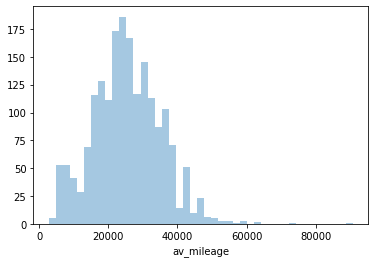

In [197]:
#calculate the average mileage in (km):
mdata['av_mileage']=data['mileage']/(2019.5-data['modelyear'])
sns.distplot(mdata['av_mileage'],kde=False)

Average mileage per year for all cars is (the unit is km/year)

In [156]:
mdata['av_mileage'].mean()

25505.29185145215

Average mileage per year for cars with different options:

In [158]:
mdata.groupby('model')['av_mileage'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
Comfortline,1180.0,24837.612741,10318.819539,3428.571429,17714.285714,25000.000000,31777.777778,90800.000000
Exclusive,59.0,20265.468769,2689.354409,9446.153846,18909.090909,20307.692308,20307.692308,28615.384615
Highline,311.0,27451.532570,9571.455497,2666.666667,21483.516484,26666.666667,33818.181818,56666.666667
Impression,95.0,27145.922807,12073.230950,3133.333333,15833.333333,23948.666667,38800.000000,64000.000000
R Line,36.0,22848.280423,6794.306211,3200.000000,23494.047619,25428.571429,25428.571429,32000.000000
Trendline,164.0,28255.005024,8417.475623,4888.888889,26152.941176,28000.000000,33333.333333,63600.000000
none,45.0,25073.504274,5538.314770,13846.153846,20000.000000,24000.000000,30769.230769,30769.230769


It appears that cars with "Exclusive" option are on the average driven significantly less than cars with other options whereas "Trendline" option appears to be driven more than the other options. "Comfortline" is the most popular option and its average mileage per year is about 25000 km per year.

Below is the average price of each option for 4 model years.

In [169]:
mdata[(mdata['modelyear'].isin([2013,2014,2015,2016]))].groupby(['modelyear','model'])[['price','av_mileage']].mean()

price    av_mileage
modelyear model                                   
2013      Comfortline  141462.895161  22561.544665
          Exclusive    148866.176471  20947.511312
          Highline     144966.216216  24543.243243
          Trendline    125877.777778  25803.418803
          none         126347.826087  29752.508361
2014      Comfortline  145223.105960  26711.070439
          Exclusive    140086.000000  19337.890909
          Highline     169118.918919  22772.742015
          Trendline    136250.000000  27665.734266
2015      Comfortline  177396.498801  27088.427391
          Highline     207907.272727  23781.688889
          Trendline    158238.755102  31276.870748
2016      Comfortline  196011.239234  24441.406699
          Highline     228881.683168  28902.280057
          R Line       245363.461538  24845.054945
          Trendline    173633.333333  29945.238095

Clearly, 'Trendline' is the lowest priced option and has the larges average mileage. 'Highline' is the most expensive and its av_mileage is less than the 'Comfortline'. The most popular 'Comfortline' option is more expansive than 'Trendline' and has less mileage. Interestingly '2013 - Exlusive' models are more expensive than 'Highline' of the same year but the '2014 - Exclusive' is less expensive than even 'Comfortline'. They are even cheaper than the previous years same option cars. This might indicate an issue with the '2014 - Exclusive options!!!

The cheaper option models having higher average mileage is partially connected to the higher mileage of these cars but also indicates that on the average cars with more expensive options were driven less!!!

**Model Year:**

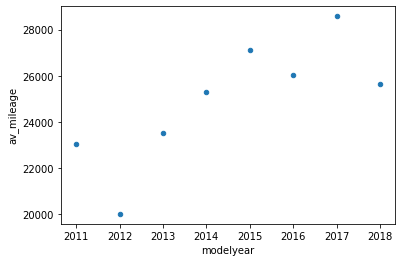

In [196]:
mdata[mdata['modelyear']>2010].groupby(['modelyear']).mean().reset_index().plot.scatter(x='modelyear',y='av_mileage')

There is a slight increase in the average mileage with model year of the car. This might be due to owners of cars with lower mileage selling them at a later date.

### Question: Is 2013 - Exclusive more expensive than 2014 - Exclusive:

Below we will download data for the Exclusive option only and compare the car pricing for 2013 and 2014 models.

In [179]:
carmodel = '/volkswagen-passat-1.6-tdi-bluemotion-exclusive'
excdata=getdata(carmodel,pages=2)
excdata

,id,model,title,link,modelyear,mileage,color,price,day,month,year,province,district
0,791331801,none,ERMAT LINE 2014 VOLKSWAGEN PASSAT 1.6 TDI BMT ...,https://www.sahibinden.com/ilan/vasita-otomobi...,2014,138960,Gri,163900,15,February,2020,İzmir,Gaziemir
1,793986792,none,Sahibinden acil satılık passat,https://www.sahibinden.com/ilan/vasita-otomobi...,2014,133000,Siyah,119000,23,February,2020,İstanbul,Büyükçekmece
2,788901242,none,2014 MODEL PASSAT 1.6 TDİ EXCLUSİVE DSG 116.00...,https://www.sahibinden.com/ilan/vasita-otomobi...,2014,116000,Beyaz,147000,23,February,2020,İzmir,Bornova
3,793897425,none,2013 hatasız boyasız otomatik dizel exclusive,https://www.sahibinden.com/ilan/vasita-otomobi...,2013,148000,Beyaz,146750,23,February,2020,Şanlıurfa,Haliliye
4,793897142,none,SİTENİN EN YAKIŞIKLISINI SATIYORUZ FABRİKASYON...,https://www.sahibinden.com/ilan/vasita-otomobi...,2013,170000,Siyah,145000,23,February,2020,Ağrı,Patnos
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,653073830,none,2013 VOLKSWAGEN PASSAT 1.6 TDİ BLUEMOTİON EXCL...,https://www.sahibinden.com/ilan/vasita-otomobi...,2013,147000,Gümüş Gri,145000,25,January,2020,Hatay,Antakya
91,783862242,none,SEVİM AUTO FARKIYLA HATASIZ BOYASIZ VW PASSAT ...,https://www.sahibinden.com/ilan/vasita-otomobi...,2013,139000,Beyaz,148000,25,January,2020,Yozgat,Sorgun
92,785555944,none,SEDA HN. OPSİYONLUDUR. VOLKSWAGEN Passat 1.6 T...,https://www.sahibinden.com/ilan/vasita-otomobi...,2013,107500,Siyah,135000,30,January,2020,Çankırı,Merkez
93,778212738,none,SAHİBİNDEN ÇOK TEMİZ PASSAT,https://www.sahibinden.com/ilan/vasita-otomobi...,2014,86600,Beyaz,153000,10,January,2020,Gaziantep,Şehitkamil


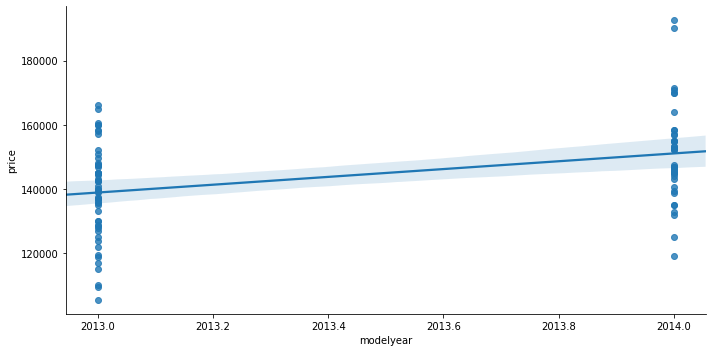

In [180]:
sns.lmplot('modelyear', 'price', data=excdata, fit_reg=True,height=5,aspect=2)

In [185]:
excdata['av_mileage']=excdata['mileage']/(2019.5-excdata['modelyear'])
excdata.groupby('modelyear').mean()

,id,mileage,price,day,year,av_mileage
modelyear,,,,,,
2013,7.844658e+08,144746.290909,138905.781818,17.290909,2019.981818,22268.660140
2014,7.847736e+08,121174.975000,151073.725000,14.625000,2020.000000,22031.813636


The data above shows that our interpretation in the previous section is not correct due to low number of data points. 2014 model is indeed more expensive than the 2013 model. It is similarly priced to 'Comfortline' but with 'av_mileage' similar to 'Highline' models. This option is not as popular as the other options which might indicate slightly lower price.